In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Set seed
torch.manual_seed(42)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
train_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\train"
test_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\test"

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 100
PATIENCE = 5

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full training dataset (with train transforms for now)
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Extract targets for stratification
targets = np.array([label for _, label in full_train_dataset])
indices = np.arange(len(full_train_dataset))

# Train-validation split
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Subsets
train_dataset = Subset(full_train_dataset, train_idx)

# Create validation dataset with different transform (test_transforms)
val_dataset = Subset(datasets.ImageFolder(train_dir, transform=test_transforms), val_idx)

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [2]:
#from sklearn.metrics import classification_report

# After evaluation
#print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


In [6]:
 import torch.nn as nn

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4, bottleneck_dim=256):
        super(AlzheimerCNN, self).__init__()

        # CNN Backbone
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 516, 3, padding=1), nn.ReLU(),
            nn.Conv2d(516, 516, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(516),
            nn.MaxPool2d(2),
        )

        # Flatten layer
        self.flatten = nn.Flatten()

        # Autoencoder bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(516 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, bottleneck_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 516 * 7 * 7),
            nn.ReLU()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(bottleneck_dim, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.flatten(x)

        # Encode and optionally decode (if training AE separately)
        encoded = self.encoder(x)
        # decoded = self.decoder(encoded)  # Optional if training AE

        # Use encoded features for classification
        out = self.classifier(encoded)
        return out
model = AlzheimerCNN(NUM_CLASSES).to(device)

In [7]:
from torchsummary import summary

# Replace with your actual model and input size
summary(model, input_size=(3, 224, 224))  # for image models, for example


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
            Conv2d-3         [-1, 16, 224, 224]           2,320
              ReLU-4         [-1, 16, 224, 224]               0
       BatchNorm2d-5         [-1, 16, 224, 224]              32
         MaxPool2d-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           4,640
              ReLU-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,248
             ReLU-10         [-1, 32, 112, 112]               0
      BatchNorm2d-11         [-1, 32, 112, 112]              64
        MaxPool2d-12           [-1, 32, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          18,496
             ReLU-14           [-1, 64,

In [6]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#ptimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping variables
#best_loss = np.inf
#counter = 0


Epoch 1/100: 100%|██████████| 256/256 [00:58<00:00,  4.34it/s]


Epoch [1/100] - Train Loss: 0.7301, Train Acc: 0.6743, Val Loss: 0.7084, Val Acc: 0.6714


Epoch 2/100: 100%|██████████| 256/256 [01:03<00:00,  4.04it/s]


Epoch [2/100] - Train Loss: 0.6673, Train Acc: 0.7065, Val Loss: 0.6316, Val Acc: 0.7280


Epoch 3/100: 100%|██████████| 256/256 [01:07<00:00,  3.78it/s]


Epoch [3/100] - Train Loss: 0.6501, Train Acc: 0.7196, Val Loss: 0.6273, Val Acc: 0.7051


Epoch 4/100: 100%|██████████| 256/256 [01:11<00:00,  3.59it/s]


Epoch [4/100] - Train Loss: 0.6423, Train Acc: 0.7198, Val Loss: 0.5454, Val Acc: 0.7422


Epoch 5/100: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s]


Epoch [5/100] - Train Loss: 0.6250, Train Acc: 0.7288, Val Loss: 0.6359, Val Acc: 0.6895


Epoch 6/100: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s]


Epoch [6/100] - Train Loss: 0.6155, Train Acc: 0.7295, Val Loss: 0.5640, Val Acc: 0.7563


Epoch 7/100: 100%|██████████| 256/256 [01:15<00:00,  3.40it/s]


Epoch [7/100] - Train Loss: 0.5851, Train Acc: 0.7467, Val Loss: 0.6833, Val Acc: 0.7114


Epoch 8/100: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s]


Epoch [8/100] - Train Loss: 0.5957, Train Acc: 0.7394, Val Loss: 1.6854, Val Acc: 0.5166


Epoch 9/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s]


Epoch [9/100] - Train Loss: 0.5833, Train Acc: 0.7469, Val Loss: 0.5834, Val Acc: 0.7417


Epoch 10/100: 100%|██████████| 256/256 [01:18<00:00,  3.26it/s]


Epoch [10/100] - Train Loss: 0.5646, Train Acc: 0.7494, Val Loss: 0.6951, Val Acc: 0.7080


Epoch 11/100: 100%|██████████| 256/256 [01:19<00:00,  3.20it/s]


Epoch [11/100] - Train Loss: 0.5551, Train Acc: 0.7552, Val Loss: 0.5780, Val Acc: 0.7480


Epoch 12/100: 100%|██████████| 256/256 [01:20<00:00,  3.17it/s]


Epoch [12/100] - Train Loss: 0.5468, Train Acc: 0.7603, Val Loss: 1.6450, Val Acc: 0.4126


Epoch 13/100: 100%|██████████| 256/256 [01:21<00:00,  3.14it/s]


Epoch [13/100] - Train Loss: 0.5529, Train Acc: 0.7625, Val Loss: 0.5028, Val Acc: 0.7817


Epoch 14/100: 100%|██████████| 256/256 [01:23<00:00,  3.05it/s]


Epoch [14/100] - Train Loss: 0.5481, Train Acc: 0.7664, Val Loss: 0.9680, Val Acc: 0.6538


Epoch 15/100: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]


Epoch [15/100] - Train Loss: 0.5201, Train Acc: 0.7784, Val Loss: 0.8360, Val Acc: 0.6562


Epoch 16/100: 100%|██████████| 256/256 [01:22<00:00,  3.10it/s]


Epoch [16/100] - Train Loss: 0.5289, Train Acc: 0.7690, Val Loss: 0.5142, Val Acc: 0.7812


Epoch 17/100: 100%|██████████| 256/256 [01:22<00:00,  3.10it/s]


Epoch [17/100] - Train Loss: 0.5225, Train Acc: 0.7771, Val Loss: 0.4646, Val Acc: 0.7944


Epoch 18/100: 100%|██████████| 256/256 [01:23<00:00,  3.06it/s]


Epoch [18/100] - Train Loss: 0.5031, Train Acc: 0.7844, Val Loss: 0.5074, Val Acc: 0.7842


Epoch 19/100: 100%|██████████| 256/256 [01:24<00:00,  3.04it/s]


Epoch [19/100] - Train Loss: 0.4962, Train Acc: 0.7872, Val Loss: 0.5146, Val Acc: 0.7783


Epoch 20/100: 100%|██████████| 256/256 [01:24<00:00,  3.04it/s]


Epoch [20/100] - Train Loss: 0.4908, Train Acc: 0.7871, Val Loss: 0.5292, Val Acc: 0.7598


Epoch 21/100: 100%|██████████| 256/256 [01:24<00:00,  3.04it/s]


Epoch [21/100] - Train Loss: 0.4995, Train Acc: 0.7927, Val Loss: 0.5843, Val Acc: 0.7622


Epoch 22/100: 100%|██████████| 256/256 [01:24<00:00,  3.03it/s]


Epoch [22/100] - Train Loss: 0.4949, Train Acc: 0.7892, Val Loss: 0.6620, Val Acc: 0.7485


Epoch 23/100: 100%|██████████| 256/256 [01:25<00:00,  2.98it/s]


Epoch [23/100] - Train Loss: 0.4681, Train Acc: 0.8055, Val Loss: 0.5191, Val Acc: 0.7773


Epoch 24/100: 100%|██████████| 256/256 [01:24<00:00,  3.03it/s]


Epoch [24/100] - Train Loss: 0.4563, Train Acc: 0.8048, Val Loss: 0.4397, Val Acc: 0.8140


Epoch 25/100: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]


Epoch [25/100] - Train Loss: 0.4539, Train Acc: 0.8118, Val Loss: 0.4746, Val Acc: 0.7925


Epoch 26/100: 100%|██████████| 256/256 [01:25<00:00,  3.01it/s]


Epoch [26/100] - Train Loss: 0.4525, Train Acc: 0.8132, Val Loss: 0.3850, Val Acc: 0.8384


Epoch 27/100: 100%|██████████| 256/256 [01:21<00:00,  3.14it/s]


Epoch [27/100] - Train Loss: 0.4299, Train Acc: 0.8149, Val Loss: 0.3973, Val Acc: 0.8315


Epoch 28/100: 100%|██████████| 256/256 [01:20<00:00,  3.16it/s]


Epoch [28/100] - Train Loss: 0.4248, Train Acc: 0.8241, Val Loss: 0.4429, Val Acc: 0.8120


Epoch 29/100: 100%|██████████| 256/256 [01:22<00:00,  3.11it/s]


Epoch [29/100] - Train Loss: 0.4271, Train Acc: 0.8187, Val Loss: 1.5595, Val Acc: 0.5283


Epoch 30/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s]


Epoch [30/100] - Train Loss: 0.4139, Train Acc: 0.8289, Val Loss: 0.3553, Val Acc: 0.8506


Epoch 31/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s]


Epoch [31/100] - Train Loss: 0.3981, Train Acc: 0.8330, Val Loss: 0.3879, Val Acc: 0.8384


Epoch 32/100: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s]


Epoch [32/100] - Train Loss: 0.4004, Train Acc: 0.8383, Val Loss: 0.4557, Val Acc: 0.8232


Epoch 33/100: 100%|██████████| 256/256 [01:19<00:00,  3.24it/s]


Epoch [33/100] - Train Loss: 0.3999, Train Acc: 0.8396, Val Loss: 0.3481, Val Acc: 0.8555


Epoch 34/100: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s]


Epoch [34/100] - Train Loss: 0.3765, Train Acc: 0.8413, Val Loss: 0.3495, Val Acc: 0.8589


Epoch 35/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s]


Epoch [35/100] - Train Loss: 0.3668, Train Acc: 0.8470, Val Loss: 0.3828, Val Acc: 0.8394


Epoch 36/100: 100%|██████████| 256/256 [01:46<00:00,  2.41it/s]


Epoch [36/100] - Train Loss: 0.3589, Train Acc: 0.8518, Val Loss: 0.4703, Val Acc: 0.8037


Epoch 37/100: 100%|██████████| 256/256 [01:10<00:00,  3.65it/s]


Epoch [37/100] - Train Loss: 0.3655, Train Acc: 0.8518, Val Loss: 0.5120, Val Acc: 0.7866


Epoch 38/100: 100%|██████████| 256/256 [01:09<00:00,  3.67it/s]


Epoch [38/100] - Train Loss: 0.3463, Train Acc: 0.8601, Val Loss: 0.3200, Val Acc: 0.8696


Epoch 39/100: 100%|██████████| 256/256 [01:12<00:00,  3.52it/s]


Epoch [39/100] - Train Loss: 0.3515, Train Acc: 0.8571, Val Loss: 1.2302, Val Acc: 0.5898


Epoch 40/100: 100%|██████████| 256/256 [01:12<00:00,  3.51it/s]


Epoch [40/100] - Train Loss: 0.3587, Train Acc: 0.8594, Val Loss: 0.2835, Val Acc: 0.8848


Epoch 41/100: 100%|██████████| 256/256 [01:13<00:00,  3.49it/s]


Epoch [41/100] - Train Loss: 0.3368, Train Acc: 0.8719, Val Loss: 0.4592, Val Acc: 0.8394


Epoch 42/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s]


Epoch [42/100] - Train Loss: 0.3254, Train Acc: 0.8699, Val Loss: 0.4061, Val Acc: 0.8433


Epoch 43/100: 100%|██████████| 256/256 [01:14<00:00,  3.45it/s]


Epoch [43/100] - Train Loss: 0.3071, Train Acc: 0.8827, Val Loss: 0.2643, Val Acc: 0.8950


Epoch 44/100: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s]


Epoch [44/100] - Train Loss: 0.3041, Train Acc: 0.8745, Val Loss: 0.3735, Val Acc: 0.8457


Epoch 45/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s]


Epoch [45/100] - Train Loss: 0.3097, Train Acc: 0.8773, Val Loss: 0.2891, Val Acc: 0.8848


Epoch 46/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s]


Epoch [46/100] - Train Loss: 0.2883, Train Acc: 0.8910, Val Loss: 0.2382, Val Acc: 0.9072


Epoch 47/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [47/100] - Train Loss: 0.2930, Train Acc: 0.8845, Val Loss: 0.3426, Val Acc: 0.8638


Epoch 48/100: 100%|██████████| 256/256 [01:21<00:00,  3.15it/s]


Epoch [48/100] - Train Loss: 0.3028, Train Acc: 0.8822, Val Loss: 0.3057, Val Acc: 0.8843


Epoch 49/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s]


Epoch [49/100] - Train Loss: 0.2738, Train Acc: 0.8928, Val Loss: 0.3010, Val Acc: 0.8945


Epoch 50/100: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s]


Epoch [50/100] - Train Loss: 0.2766, Train Acc: 0.8940, Val Loss: 0.4029, Val Acc: 0.8491


Epoch 51/100: 100%|██████████| 256/256 [01:16<00:00,  3.34it/s]


Epoch [51/100] - Train Loss: 0.2644, Train Acc: 0.8958, Val Loss: 0.2441, Val Acc: 0.9043


Epoch 52/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [52/100] - Train Loss: 0.2661, Train Acc: 0.8964, Val Loss: 0.2435, Val Acc: 0.9023


Epoch 53/100: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s]


Epoch [53/100] - Train Loss: 0.7192, Train Acc: 0.7052, Val Loss: 0.5066, Val Acc: 0.7837


Epoch 54/100: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s]


Epoch [54/100] - Train Loss: 0.5144, Train Acc: 0.7849, Val Loss: 0.4493, Val Acc: 0.8115


Epoch 55/100: 100%|██████████| 256/256 [01:15<00:00,  3.39it/s]


Epoch [55/100] - Train Loss: 0.4624, Train Acc: 0.8096, Val Loss: 0.4151, Val Acc: 0.8237


Epoch 56/100: 100%|██████████| 256/256 [01:18<00:00,  3.27it/s]


Epoch [56/100] - Train Loss: 0.4166, Train Acc: 0.8260, Val Loss: 0.3596, Val Acc: 0.8384


Epoch 57/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s]


Epoch [57/100] - Train Loss: 0.3844, Train Acc: 0.8425, Val Loss: 0.3433, Val Acc: 0.8545


Epoch 58/100: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s]


Epoch [58/100] - Train Loss: 0.3573, Train Acc: 0.8534, Val Loss: 0.3249, Val Acc: 0.8633


Epoch 59/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s]


Epoch [59/100] - Train Loss: 0.3450, Train Acc: 0.8579, Val Loss: 1.3814, Val Acc: 0.8804


Epoch 60/100: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


Epoch [60/100] - Train Loss: 0.3186, Train Acc: 0.8710, Val Loss: 0.2638, Val Acc: 0.8940


Epoch 61/100: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


Epoch [61/100] - Train Loss: 0.3269, Train Acc: 0.8710, Val Loss: 0.2603, Val Acc: 0.9004


Epoch 62/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [62/100] - Train Loss: 0.2873, Train Acc: 0.8883, Val Loss: 0.2794, Val Acc: 0.8940


Epoch 63/100: 100%|██████████| 256/256 [01:16<00:00,  3.33it/s]


Epoch [63/100] - Train Loss: 0.2852, Train Acc: 0.8885, Val Loss: 0.2252, Val Acc: 0.9160


Epoch 64/100: 100%|██████████| 256/256 [01:17<00:00,  3.30it/s]


Epoch [64/100] - Train Loss: 0.2671, Train Acc: 0.8948, Val Loss: 0.1876, Val Acc: 0.9243


Epoch 65/100: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s]


Epoch [65/100] - Train Loss: 0.2533, Train Acc: 0.9037, Val Loss: 0.2898, Val Acc: 0.8794


Epoch 66/100: 100%|██████████| 256/256 [01:18<00:00,  3.24it/s]


Epoch [66/100] - Train Loss: 0.2439, Train Acc: 0.9078, Val Loss: 0.1991, Val Acc: 0.9248


Epoch 67/100: 100%|██████████| 256/256 [01:19<00:00,  3.23it/s]


Epoch [67/100] - Train Loss: 0.2314, Train Acc: 0.9110, Val Loss: 0.1898, Val Acc: 0.9312


Epoch 68/100: 100%|██████████| 256/256 [01:20<00:00,  3.17it/s]


Epoch [68/100] - Train Loss: 0.2515, Train Acc: 0.9060, Val Loss: 0.1949, Val Acc: 0.9282


Epoch 69/100: 100%|██████████| 256/256 [01:20<00:00,  3.17it/s]


Epoch [69/100] - Train Loss: 0.2244, Train Acc: 0.9155, Val Loss: 0.2288, Val Acc: 0.9146


Epoch 70/100: 100%|██████████| 256/256 [01:21<00:00,  3.15it/s]


Epoch [70/100] - Train Loss: 0.2400, Train Acc: 0.9071, Val Loss: 0.1696, Val Acc: 0.9326


Epoch 71/100: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]


Epoch [71/100] - Train Loss: 0.2115, Train Acc: 0.9191, Val Loss: 0.1986, Val Acc: 0.9292


Epoch 72/100: 100%|██████████| 256/256 [01:21<00:00,  3.14it/s]


Epoch [72/100] - Train Loss: 0.2156, Train Acc: 0.9186, Val Loss: 0.2627, Val Acc: 0.9097


Epoch 73/100: 100%|██████████| 256/256 [01:25<00:00,  2.98it/s]


Epoch [73/100] - Train Loss: 0.2183, Train Acc: 0.9203, Val Loss: 0.1826, Val Acc: 0.9292


Epoch 74/100: 100%|██████████| 256/256 [01:20<00:00,  3.18it/s]


Epoch [74/100] - Train Loss: 0.2060, Train Acc: 0.9254, Val Loss: 0.2656, Val Acc: 0.9067


Epoch 75/100: 100%|██████████| 256/256 [01:21<00:00,  3.15it/s]


Epoch [75/100] - Train Loss: 0.1993, Train Acc: 0.9220, Val Loss: 0.2017, Val Acc: 0.9326


Epoch 76/100: 100%|██████████| 256/256 [01:22<00:00,  3.11it/s]


Epoch [76/100] - Train Loss: 0.2074, Train Acc: 0.9218, Val Loss: 0.2818, Val Acc: 0.9092


Epoch 77/100: 100%|██████████| 256/256 [01:21<00:00,  3.12it/s]


Epoch [77/100] - Train Loss: 0.1886, Train Acc: 0.9293, Val Loss: 0.2538, Val Acc: 0.9004


Epoch 78/100: 100%|██████████| 256/256 [01:22<00:00,  3.11it/s]


Epoch [78/100] - Train Loss: 0.2188, Train Acc: 0.9241, Val Loss: 0.1894, Val Acc: 0.9316


Epoch 79/100: 100%|██████████| 256/256 [01:22<00:00,  3.11it/s]


Epoch [79/100] - Train Loss: 0.1993, Train Acc: 0.9261, Val Loss: 0.1884, Val Acc: 0.9292


Epoch 80/100: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]


Epoch [80/100] - Train Loss: 0.1904, Train Acc: 0.9283, Val Loss: 1.0480, Val Acc: 0.6660


Epoch 81/100: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]


Epoch [81/100] - Train Loss: 0.1860, Train Acc: 0.9297, Val Loss: 0.1718, Val Acc: 0.9385


Epoch 82/100: 100%|██████████| 256/256 [01:22<00:00,  3.10it/s]


Epoch [82/100] - Train Loss: 0.1841, Train Acc: 0.9337, Val Loss: 0.2101, Val Acc: 0.9229


Epoch 83/100: 100%|██████████| 256/256 [01:22<00:00,  3.09it/s]


Epoch [83/100] - Train Loss: 0.1810, Train Acc: 0.9343, Val Loss: 0.2086, Val Acc: 0.9229


Epoch 84/100: 100%|██████████| 256/256 [01:22<00:00,  3.09it/s]


Epoch [84/100] - Train Loss: 0.1759, Train Acc: 0.9359, Val Loss: 0.1969, Val Acc: 0.9287


Epoch 85/100: 100%|██████████| 256/256 [01:24<00:00,  3.02it/s]


Epoch [85/100] - Train Loss: 0.1773, Train Acc: 0.9401, Val Loss: 0.2249, Val Acc: 0.9175


Epoch 86/100: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s]


Epoch [86/100] - Train Loss: 0.1900, Train Acc: 0.9302, Val Loss: 0.2730, Val Acc: 0.9028


Epoch 87/100: 100%|██████████| 256/256 [01:15<00:00,  3.40it/s]


Epoch [87/100] - Train Loss: 0.1660, Train Acc: 0.9402, Val Loss: 0.1973, Val Acc: 0.9287


Epoch 88/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s]


Epoch [88/100] - Train Loss: 0.1732, Train Acc: 0.9408, Val Loss: 0.1679, Val Acc: 0.9414


Epoch 89/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s]


Epoch [89/100] - Train Loss: 0.1728, Train Acc: 0.9371, Val Loss: 0.1825, Val Acc: 0.9399


Epoch 90/100: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s]


Epoch [90/100] - Train Loss: 0.1744, Train Acc: 0.9359, Val Loss: 0.1483, Val Acc: 0.9473


Epoch 91/100: 100%|██████████| 256/256 [01:14<00:00,  3.46it/s]


Epoch [91/100] - Train Loss: 0.1559, Train Acc: 0.9436, Val Loss: 0.1455, Val Acc: 0.9458


Epoch 92/100: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s]


Epoch [92/100] - Train Loss: 0.1533, Train Acc: 0.9463, Val Loss: 0.1402, Val Acc: 0.9463


Epoch 93/100: 100%|██████████| 256/256 [01:22<00:00,  3.09it/s]


Epoch [93/100] - Train Loss: 0.1677, Train Acc: 0.9429, Val Loss: 0.1661, Val Acc: 0.9409


Epoch 94/100: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s]


Epoch [94/100] - Train Loss: 0.1667, Train Acc: 0.9441, Val Loss: 0.1682, Val Acc: 0.9390


Epoch 95/100: 100%|██████████| 256/256 [01:14<00:00,  3.42it/s]


Epoch [95/100] - Train Loss: 0.1492, Train Acc: 0.9463, Val Loss: 0.1392, Val Acc: 0.9502


Epoch 96/100: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


Epoch [96/100] - Train Loss: 0.1428, Train Acc: 0.9485, Val Loss: 0.1864, Val Acc: 0.9312


Epoch 97/100: 100%|██████████| 256/256 [01:14<00:00,  3.44it/s]


Epoch [97/100] - Train Loss: 0.1552, Train Acc: 0.9435, Val Loss: 0.1469, Val Acc: 0.9487


Epoch 98/100: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


Epoch [98/100] - Train Loss: 0.1540, Train Acc: 0.9448, Val Loss: 0.1702, Val Acc: 0.9448


Epoch 99/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [99/100] - Train Loss: 0.1293, Train Acc: 0.9553, Val Loss: 0.2174, Val Acc: 0.9390


Epoch 100/100: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [100/100] - Train Loss: 0.1492, Train Acc: 0.9481, Val Loss: 0.1402, Val Acc: 0.9482


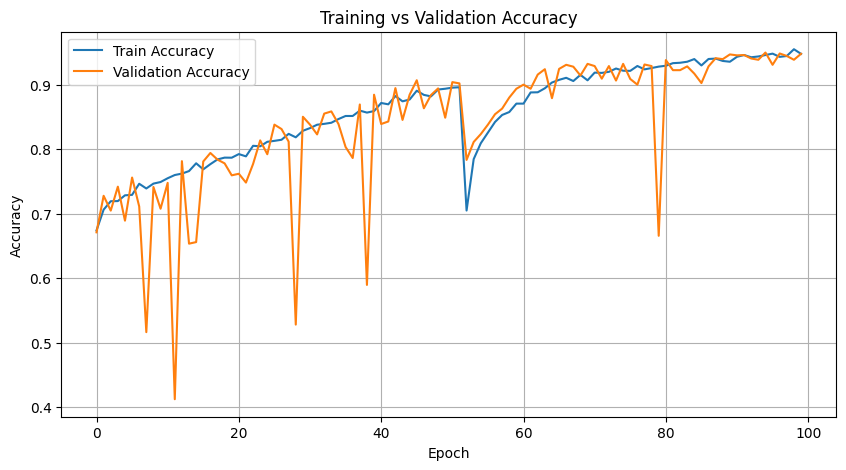

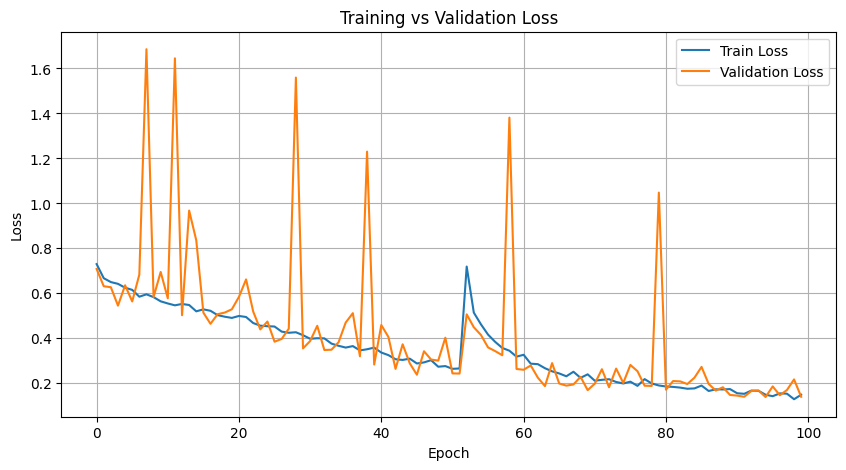

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

targets = np.array([label for _, label in full_train_dataset])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store accuracies for plotting
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Early stopping variables
best_val_accuracy = 0.0
patience_counter = 0

# Training loop
for epoch in range(EPOCHS):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train.double() / total_train
    train_accuracies.append(train_accuracy.item())
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels.data)
            total_val += labels.size(0)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val.double() / total_val
    val_accuracies.append(val_accuracy.item())
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"- Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#    # Early stopping
 #   if val_accuracy > best_val_accuracy:
  #      best_val_accuracy = val_accuracy
  ##      patience_counter = 0
    #    torch.save(model.state_dict(), "best_model.pth")  # Save best model
    #else:
     #   patience_counter += 1
      ##     print("Early stopping triggered.")
        #    break

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Loss")
plt.show()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_7792\1042605793.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


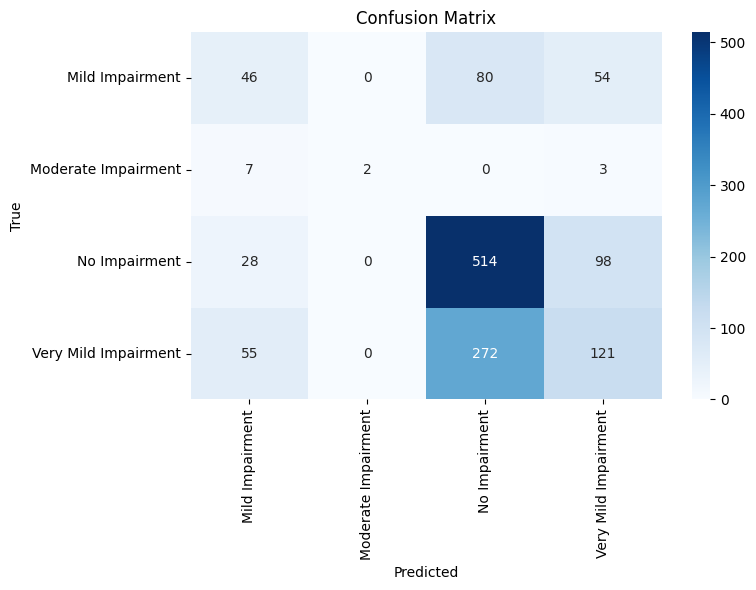

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model (optional if already in memory)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Get predictions and true labels for test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # e.g., ['MildDemented', 'ModerateDemented', ...]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)



Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.34      0.26      0.29       180
 Moderate Impairment       1.00      0.17      0.29        12
       No Impairment       0.59      0.80      0.68       640
Very Mild Impairment       0.44      0.27      0.33       448

            accuracy                           0.53      1280
           macro avg       0.59      0.37      0.40      1280
        weighted avg       0.51      0.53      0.50      1280

